In [1]:
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
import pandas as pd
import numpy as np
#leanse la documentacion de socceraction, es buenisimo lo que tienen. https://socceraction.readthedocs.io/en/latest/

In [20]:
#import mi df, este df ya tiene hechas todas las consideraciones necesarias para que el formato spadl lo tome.
df = pd.read_excel('TODOSLOSEVENTOS.xlsx', sheet_name='Hoja2')

In [22]:
#relleno los 0
df[['end_x','end_y']] = df[['end_x', 'end_y']].fillna(0)

In [23]:
#la libreria de xThreat está armada para estas dimensiones los datos estan en 100x100
df['start_x'] = df['start_x'] * 1.05
df['start_y'] = df['start_y'] * 0.68
df['end_x'] = df['end_x'] * 1.05
df['end_y'] = df['end_y'] * 0.68

In [24]:
#planteo el modelo para el grid
xTModel = xthreat.ExpectedThreat(l=12, w=8)
xTModel.fit(df)
xTModel.save_model(filepath='gridxT.json') #para guardar

# iterations:  20


In [25]:
#planteo el calculo de xT para cada una de las acciones de pase.
mov_actions = xthreat.get_successful_move_actions(df)
mov_actions["xT_value"] = xTModel.predict(mov_actions)
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

[0.00686787 0.00431911 0.00429425 ... 0.00566596 0.00431047 0.00424181]


,type_name,start_x,start_y,end_x,end_y,xT_value
0,pass,52.500,34.000,38.745,36.720,-0.002549
1,pass,38.745,36.720,36.435,25.636,-0.000071
2,pass,38.325,24.140,36.540,7.208,-0.000780
3,pass,36.330,9.316,27.510,20.468,-0.000473
4,pass,30.765,21.352,29.190,50.184,-0.000099
5,pass,30.660,50.864,28.875,35.904,0.000246
6,pass,32.760,28.084,40.740,8.432,0.000046
8,pass,47.565,59.704,59.850,59.704,0.001355
9,pass,64.155,58.956,66.990,67.048,-0.000789
11,pass,43.365,0.000,36.435,4.624,0.000000


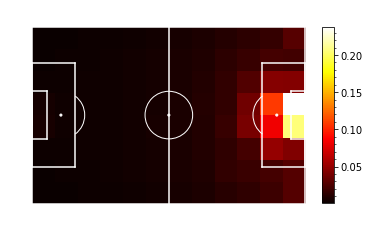

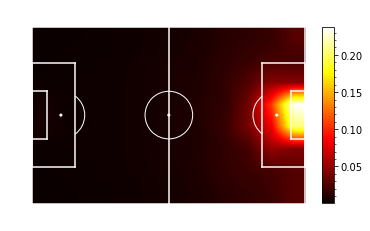

<AxesSubplot:>

In [30]:
#visualizo para entender que los valores tengan sentido. A valor mas alto, mas peligro, deberia ser un pase completado mas cerca del arco.
import matplotsoccer as mps
import numpy as np
import matplotlib.pyplot as plt

# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")


# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

In [53]:
#defino partido.
partido = pd.read_excel('2022-07-21 - Lanus vs Velez Sarsfield LPF2022.xlsx')

In [55]:
partido.shape

(1522, 32)

In [56]:
#filtro por acciones de tiro y pase nomas.
partido = partido[(partido['isShot'] == 1) | (partido['displayName.1'] == 'Pass')]

In [57]:
partido.shape

(958, 32)

In [68]:
#funciones para pasar del formato del partido al formato spadl.
def parseo_spadl(partido):
    partido.rename(columns={
        "id":"game_id",
        "eventId":"event_id",
        "teamId":"team_id",
        "x": "start_x",
        "y": "start_y",
        "endX":"end_x",
        "endY":"end_y",
        "value.1": "type_id",
        "displayName.1": "type_name",
        "value.2": "result_id",
        "displayName.2": "result_name",
        "playerId": "player_id"
    }, inplace=True)
    partido['type_name'] = np.where(partido['isShot'] == 1, 'shot', 'pass')
    partido['type_id'] = np.where(partido['isShot'] == 1, 11, 0)
    partido['isGoal'] = partido.isGoal.fillna(0)
    partido['result_name'] = np.where((partido['type_name'] == 'shot') & (partido['isGoal'] != 1), 'fail', np.where((partido['result_id'] != 1) & (partido['type_name'] == 'pass'), 'Unsuccessful', 'Successful'))
    partido[['end_x','end_y']] = partido[['end_x', 'end_y']].fillna(0)
    partido['start_x'] = partido['start_x'] * 1.05
    partido['start_y'] = partido['start_y'] * 0.68
    partido['end_x'] = partido['end_x'] * 1.05
    partido['end_y'] = partido['end_y'] * 0.68

In [69]:
parseo_spadl(partido)

In [61]:
#calculo acciones para el partido.
mov_actions = xthreat.get_successful_move_actions(partido)
mov_actions["xT_value"] = xTModel.predict(mov_actions)
mov_actions[["type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]][:10]

[0.00686787 0.00346824 0.00223108 0.00731742 0.01547894 0.00976342
 0.00731742 0.01063442 0.00731742 0.00566596 0.00537905 0.00346824
 0.00424181 0.00430922 0.00341558 0.00424181 0.00356215 0.00335554
 0.00335554 0.00261378 0.00201817 0.00496942 0.00600467 0.00216022
 0.00099118 0.01513067 0.00357492 0.00299408 0.00431047 0.00660438
 0.00569248 0.00660438 0.00731742 0.00686787 0.00496942 0.0085277
 0.00341558 0.00731742 0.00341558 0.00335073 0.00331612 0.02796474
 0.00517145 0.00356215 0.00424769 0.00430922 0.00388837 0.00424181
 0.00496942 0.00335554 0.00277369 0.00936493 0.00673125 0.00773879
 0.00537905 0.00431911 0.00424181 0.00431911 0.00299408 0.00388564
 0.00261378 0.00335554 0.00431047 0.00341558 0.00356215 0.00388564
 0.00731742 0.00431911 0.00429425 0.0147649  0.02173926 0.02173926
 0.0146249  0.02770308 0.00566596 0.0085277  0.00341558 0.00275911
 0.00600467 0.00142335 0.00201817 0.00331612 0.00346824 0.00504847
 0.00341558 0.00429425 0.00431911 0.00706259 0.00660438 0.00731

,type_name,start_x,start_y,end_x,end_y,xT_value
2,pass,52.605,34.000,33.180,31.756,-0.003400
3,pass,33.285,31.892,73.605,55.896,0.009613
7,pass,21.525,0.000,41.055,15.436,0.001657
9,pass,56.595,44.812,74.970,45.424,0.008162
12,pass,74.235,44.676,69.090,33.524,-0.005716
14,pass,67.620,32.708,60.690,45.424,-0.002446
15,pass,60.690,45.424,62.055,39.508,0.003317
16,pass,62.055,39.508,58.590,46.308,-0.003317
17,pass,58.590,46.308,55.755,63.444,-0.001651
18,pass,55.755,63.444,49.035,51.136,-0.000697


In [62]:
#agrupar por jugador para entender que jugadores fueron los de más xT.
mov_actions.groupby('jugador').sum()['xT_value'].sort_values(ascending=False)

jugador
Francisco Ortega        0.249052
Julián Fernández        0.209071
Samuel Careaga          0.191098
Franco Orozco           0.181683
Luca Orellano           0.172486
Santiago Cáseres        0.127430
Matías Pérez            0.115291
Julián Aude             0.101081
Valentín Gómez          0.075575
Walter Bou              0.055719
Leonardo Jara           0.054826
Matías Vera             0.045593
Lautaro Acosta          0.043441
Diego Godín             0.038400
Mateo Sanabria          0.037676
Máximo Perrone          0.031362
Leonel Di Plácido       0.024297
Franco Ortellado        0.024102
Lucas Janson            0.015278
Lucas Hoyos             0.011294
Lucas Pratto            0.010222
José Sand               0.008581
Raúl Loaiza             0.007486
Brian Blando            0.005450
Santiago Castro        -0.001417
Fernando Monetti       -0.005024
Maximiliano González   -0.007711
Nicolás Garayalde      -0.009431
Joel Soñora            -0.024493
Abiel Osorio           -0.041574
Na